In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as sqlio
import numpy as np
import matplotlib.pyplot as pp
import config

### SETUP

In [4]:
SAVE_CSV = True
TEST = True

In [5]:
pp.rcParams.update({'font.size': 20})

In [6]:
conn = psycopg2.connect(**(config.config()))
cur = conn.cursor()
sql = "SELECT * FROM evaluation"
df = sqlio.read_sql_query(sql, conn)
conn.close()

/Users/aun/Desktop/Folders/Work/Github/resource-based-checklist-generation/database/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [7]:
df['time'] = df['time'].astype(int)
filtered_in = ['6G4M4n', 'uu22lG', '5gcUdG', 'rMjmUj', 'NA59pU', 'Cm4Nxv', 'hHifeb', 'ejfDmp', '6N1rxX', 'OaR42K', 'So0sLr', 'rizKmQ', 'eH9MMC', '9kh95F']
filtered_df = df[(df['id'].isin(filtered_in))].groupby('id').filter(lambda group: len(group) == 4)

In [8]:
list_tasks = [
              list(filtered_df.groupby('task').get_group('task1')['result']),
              list(filtered_df.groupby('task').get_group('task2')['result']),
              list(filtered_df.groupby('task').get_group('task3')['result']),
]

### Calculate Avg. Time Performing Each Task

In [9]:
nano_to_sec_convertion = 1e9
completed_evaluation = pd.DataFrame(filtered_df[['id', 'task']])
completed_evaluation['avg'] =  filtered_df.sort_values(['id', 'time']).groupby('id')['time'].diff(1) / nano_to_sec_convertion
time_taken = completed_evaluation.groupby('task')['avg'].mean().dropna().reset_index()
time_taken['avg'] = pd.to_datetime(time_taken['avg'], unit='s').dt.strftime("%M:%S")
time_taken

,task,avg
0,task1,15:46
1,task2,06:00
2,task3,12:59


In [10]:
survey_time = filtered_df[(filtered_df['task'] == 'booking') | (filtered_df['task'] == 'task3')].sort_values(['id', 'time']).groupby('id')['time'].diff(1) / nano_to_sec_convertion
avg_time_taken = survey_time.dropna().mean()
print(f'Average time taken to finish all the tasks: {int(avg_time_taken // 60)}:{(avg_time_taken % 60).round(2)} min ({avg_time_taken.round(2)} seconds)')

Average time taken to finish all the tasks: 34:46.52 min (2086.52 seconds)


In [11]:
def objs_exist(arr, fields, exist=1):
  return len([a for a in arr if all(str(a[k]).strip() == str(v) for k, v in fields.items())]) == exist

### Task 1

In [12]:
task1_checklist = []
task_no = 0

for item in list_tasks[task_no]:
  task_checklist = {}
  tx_details = item['information'][0]['details']
  task_checklist['form_name'] = item['name'] == 'Card Details Form'
  task_checklist['information_name'] = item['information'][0]['name'] == 'Purchased Items'
  task_checklist['customer_id_hide'] = objs_exist(tx_details, {'inputDependencyField': 'customer_id'})
  task_checklist['order_name'] = objs_exist(tx_details, {'name': 'Order ID'})
  task_checklist['total_price'] = objs_exist(tx_details, {'inputDependencyField': 'total_price', 'name': 'Total Price'})
  task_checklist['tx_id'] = objs_exist(tx_details, {'inputDependencyField': 'id', 'queryTable': 'transactions', 'queryField': 'id'})
  task_checklist['tx_id_name'] = objs_exist(tx_details, {'inputDependencyField': 'id', 'queryTable': 'transactions', 'queryField': 'id', 'name': 'Transaction ID'})
  task_checklist['item_id'] = objs_exist(tx_details, {'inputDependencyField': 'id', 'queryTable': 'item_list', 'queryField': 'item_id'})
  task_checklist['item_id_name'] = objs_exist(tx_details, {'inputDependencyField': 'id', 'queryTable': 'item_list', 'queryField': 'item_id', 'name': 'Item ID'})

  task_checklist['c_len'] = len(item['components']) == 1
  task_checklist['c_header'] = objs_exist(item['components'], {'componentType': 'HEADER', 'order': 0, 'name': 'Card Details'})
  card_form = task_checklist['c_len'] and item['components'][0]['children']
  task_checklist['c_child_len'] = task_checklist['c_len'] and len(item['components'][0]['children']) == 3
  task_checklist['c_card_no'] = task_checklist['c_len'] and objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Card Number'})
  task_checklist['c_expire'] = task_checklist['c_len'] and objs_exist(card_form, {'componentType': 'DATE', 'name': 'Expire Date'})
  task_checklist['c_code'] = task_checklist['c_len'] and objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Security Code'})
  task_checklist['c_card_no_ode'] = task_checklist['c_len'] and objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Card Number', 'outputDependency': 'CardDetails', 'outputDependencyField': 'card_no'})
  task_checklist['c_expire_ode'] = task_checklist['c_len'] and objs_exist(card_form, {'componentType': 'DATE', 'name': 'Expire Date', 'outputDependency': 'CardDetails', 'outputDependencyField': 'expire'})
  task_checklist['c_code_ode'] = task_checklist['c_len'] and objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Security Code', 'outputDependency': 'CardDetails', 'outputDependencyField': 'code'})
  task_checklist['c_card_no_ide'] = task_checklist['c_len'] and objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Card Number', 'outputDependency': 'CardDetails', 'inputDependencyField': ''})
  task_checklist['c_expire_ide'] = task_checklist['c_len'] and objs_exist(card_form, {'componentType': 'DATE', 'name': 'Expire Date', 'outputDependency': 'CardDetails', 'inputDependencyField': ''})
  task_checklist['c_code_ide'] = task_checklist['c_len'] and objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Security Code', 'outputDependency': 'CardDetails', 'inputDependencyField': ''})

  task_checklist['accuracy'] = list(task_checklist.values()).count(True) / len(task_checklist.values())
  task1_checklist.append(task_checklist)

In [13]:
df_task1_checklist = pd.DataFrame(task1_checklist)
task1_results = pd.concat([df_task1_checklist, pd.DataFrame(df_task1_checklist.mean(numeric_only=True, axis=0)).transpose()]).reset_index().drop(columns='index')
if SAVE_CSV: task1_results.to_csv('task1_results.csv')
task1_results

,form_name,information_name,customer_id_hide,order_name,total_price,tx_id,tx_id_name,item_id,item_id_name,c_len,...,c_card_no,c_expire,c_code,c_card_no_ode,c_expire_ode,c_code_ode,c_card_no_ide,c_expire_ide,c_code_ide,accuracy
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,1.000000
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,1.000000
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,1.000000
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,1.000000
4,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.095238
5,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,0.952381
6,True,True,True,True,True,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,0.428571
7,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,False,True,True,False,True,0.857143
8,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,0.952381
9,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,0.952381


In [14]:
print(round(task1_results['accuracy'].head(13).std(),2))
print(round(min(task1_results['accuracy'].head(13)),2))
print(round(max(task1_results['accuracy'].head(13)),2))

0.28
0.1
1.0


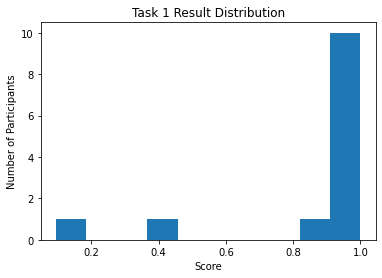

In [15]:
pp.hist(task1_results['accuracy'].head(13))
# pp.xlim([0, 1])
pp.title("Task 1 Result Distribution")
pp.xlabel("Score")
pp.ylabel("Number of Participants")
pp.show()

### Task 2

In [16]:
task2_checklist = []
task_no = 1

for item in list_tasks[task_no]:
  task_checklist = {}
  tx_details = item['information'][0]['details']
  task_checklist['form_name'] = item['name'] == 'Card Details Form'
  task_checklist['information_name'] = item['information'][0]['name'] == 'Purchased Items'
  task_checklist['customer_id_hide'] = objs_exist(tx_details, {'inputDependencyField': 'customer_id'})
  task_checklist['order_name'] = objs_exist(tx_details, {'name': 'Order ID'})
  task_checklist['total_price'] = objs_exist(tx_details, {'inputDependencyField': 'total_price', 'name': 'Total Price'})
  task_checklist['tx_id'] = objs_exist(tx_details, {'inputDependencyField': 'id', 'queryTable': 'transactions', 'queryField': 'id'})
  task_checklist['tx_id_name'] = objs_exist(tx_details, {'inputDependencyField': 'id', 'queryTable': 'transactions', 'queryField': 'id', 'name': 'Transaction ID'})
  task_checklist['item_id'] = objs_exist(tx_details, {'inputDependencyField': 'id', 'queryTable': 'item_list', 'queryField': 'item_id'})
  task_checklist['item_id_name'] = objs_exist(tx_details, {'inputDependencyField': 'id', 'queryTable': 'item_list', 'queryField': 'item_id', 'name': 'Item ID'})

  task_checklist['c_len'] = len(item['components']) == 1
  task_checklist['c_header'] = objs_exist(item['components'], {'componentType': 'HEADER', 'order': 0, 'name': 'Card Details'})
  card_form = item['components'][0]['children']
  task_checklist['c_child_len'] = len(item['components'][0]['children']) == 3
  task_checklist['c_card_no'] = objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Card Number'})
  task_checklist['c_expire'] = objs_exist(card_form, {'componentType': 'DATE', 'name': 'Expire Date'})
  task_checklist['c_code'] = objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Security Code'})
  task_checklist['c_card_no_ode'] = objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Card Number', 'outputDependency': 'CardDetails', 'outputDependencyField': 'card_no'})
  task_checklist['c_expire_ode'] = objs_exist(card_form, {'componentType': 'DATE', 'name': 'Expire Date', 'outputDependency': 'CardDetails', 'outputDependencyField': 'expire'})
  task_checklist['c_code_ode'] = objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Security Code', 'outputDependency': 'CardDetails', 'outputDependencyField': 'code'})
  task_checklist['c_card_no_ide'] = objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Card Number', 'outputDependency': 'CardDetails', 'inputDependencyField': ''})
  task_checklist['c_expire_ide'] = objs_exist(card_form, {'componentType': 'DATE', 'name': 'Expire Date', 'outputDependency': 'CardDetails', 'inputDependencyField': ''})
  task_checklist['c_code_ide'] = objs_exist(card_form, {'componentType': 'INPUT', 'name': 'Security Code', 'outputDependency': 'CardDetails', 'inputDependencyField': ''})
  
  task_checklist['accuracy'] = list(task_checklist.values()).count(True) / len(task_checklist.values())
  task2_checklist.append(task_checklist)

In [17]:
df_task2_checklist = pd.DataFrame(task2_checklist)
task2_results = pd.concat([df_task2_checklist, pd.DataFrame(df_task2_checklist.mean(numeric_only=True, axis=0)).transpose()]).reset_index().drop(columns='index')
if SAVE_CSV: task2_results.to_csv('task2_results.csv')
task2_results

,form_name,information_name,customer_id_hide,order_name,total_price,tx_id,tx_id_name,item_id,item_id_name,c_len,...,c_card_no,c_expire,c_code,c_card_no_ode,c_expire_ode,c_code_ode,c_card_no_ide,c_expire_ide,c_code_ide,accuracy
0,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,0.904762
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,0.952381
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,1.000000
3,True,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,0.952381
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,1.000000
5,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,1.000000
6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,1.000000
7,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,0.952381
8,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,False,True,True,False,True,0.809524
9,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,False,True,True,False,True,0.809524


In [18]:
print(round(task2_results['accuracy'].head(13).std(),2))
print(round(min(task2_results['accuracy'].head(13)),2))
print(round(max(task2_results['accuracy'].head(13)),2))

0.08
0.81
1.0


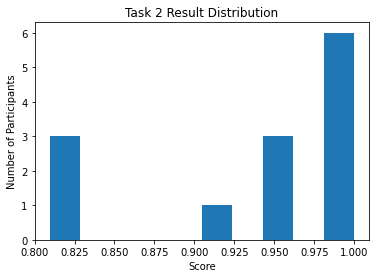

In [19]:
pp.hist(task2_results['accuracy'].head(13))
# pp.xlim([0, 1])
pp.title("Task 2 Result Distribution")
pp.xlabel("Score")
pp.ylabel("Number of Participants")
pp.show()

### Task 3

In [20]:
task3_checklist = []
task_no = 2

for item in list_tasks[task_no]:
  task_checklist = {}
  task_checklist['form_name'] = item['name'] == 'Award Contract Checklist'
  
  task_checklist['service_hide'] = len([a for a in item['information'][0]['details'] if a['hide']]) == 4
  task_checklist['contract_hide'] = len([a for a in item['information'][1]['details'] if a['hide']]) == 5
  task_checklist['provider_name'] = len([a for a in item['information'][0]['details'] if a['inputDependencyField'] == 'actorid' and a['queryTable'] == 'staff' and a['queryField'] == 'name']) == 1
  task_checklist['provider_name_fname'] = len([a for a in item['information'][0]['details'] if a['inputDependencyField'] == 'actorid' and a['queryTable'] == 'staff' and a['queryField'] == 'name' and a['name'] == "Provider's Name"]) == 1
  task_checklist['provider_surname'] = len([a for a in item['information'][0]['details'] if a['inputDependencyField'] == 'actorid' and a['queryTable'] == 'staff' and a['queryField'] == 'surname']) == 1
  task_checklist['provider_surname_fname'] = len([a for a in item['information'][0]['details'] if a['inputDependencyField'] == 'actorid' and a['queryTable'] == 'staff' and a['queryField'] == 'surname' and a['name'] == "Provider's Surname"]) == 1
  task_checklist['service_name'] = len([a for a in item['information'][0]['details'] if a['inputDependencyField'] == 'serviceid' and a['queryTable'] == 'services' and a['queryField'] == 'name']) == 1
  task_checklist['service_name_fname'] = len([a for a in item['information'][0]['details'] if a['inputDependencyField'] == 'serviceid' and a['queryTable'] == 'services' and a['queryField'] == 'name' and a['name'] == "Service Name"]) == 1
  task_checklist['service_desc'] = len([a for a in item['information'][0]['details'] if a['inputDependencyField'] == 'serviceid' and a['queryTable'] == 'services' and a['queryField'] == 'description']) == 1
  task_checklist['service_desc_fname'] = len([a for a in item['information'][0]['details'] if a['inputDependencyField'] == 'serviceid' and a['queryTable'] == 'services' and a['queryField'] == 'description' and a['name'] == "Service Description"]) == 1
  task_checklist['patient_id'] = len([a for a in item['information'][1]['details'] if a['inputDependencyField'] == 'reqservid' and a['queryTable'] == 'requestedservices' and a['queryField'] == 'patientid']) == 1
  task_checklist['patient_id_fname'] = len([a for a in item['information'][1]['details'] if a['inputDependencyField'] == 'reqservid' and a['queryTable'] == 'requestedservices' and a['queryField'] == 'patientid' and a['name'] == "Patient ID"]) == 1

  task_checklist['c_len'] = len(item['components']) == 1
  task_checklist['c_header'] = objs_exist(item['components'], {'componentType': 'HEADER', 'name': 'Open Contract'})
  contract_form = item['components'][0]['children'] if item['components'][0] else []
  task_checklist['c_child_len'] = len(contract_form) == 6
  task_checklist['c_idcontract'] = objs_exist(contract_form, {'inputDependencyField': 'idcontract', 'outputDependencyField': 'idcontract', 'hide': True})
  task_checklist['c_reqservid'] = objs_exist(contract_form, {'inputDependencyField': 'reqservid', 'outputDependencyField': 'reqservid', 'hide': True})
  task_checklist['c_providerid'] = objs_exist(contract_form, {'inputDependencyField': 'providerid', 'outputDependencyField': 'providerid', 'hide': True})
  task_checklist['c_time_requested'] = objs_exist(contract_form, {'inputDependencyField': 'time_requested', 'outputDependencyField': 'time_requested', 'hide': True})
  task_checklist['c_time_opened'] = objs_exist(contract_form, {'inputDependencyField': '', 'outputDependencyField': 'time_opened', 'hide': False, 'name': 'Date Opened', 'componentType': 'DATE', 'required': True})
  task_checklist['c_stateid'] = objs_exist(contract_form, {'inputDependencyField': '', 'outputDependencyField': 'stateid', 'hide': False, 'name': 'Opened State', 'componentType': 'CONSTANT', 'required': True, 'validation': '3'})

  task_checklist['accuracy'] = list(task_checklist.values()).count(True) / len(task_checklist.values())
  task3_checklist.append(task_checklist)

In [21]:
df_task3_checklist = pd.DataFrame(task3_checklist)
task3_results = pd.concat([df_task3_checklist, pd.DataFrame(df_task3_checklist.mean(numeric_only=True, axis=0)).transpose()]).reset_index().drop(columns='index')
if SAVE_CSV: task3_results.to_csv('task3_results.csv')
task3_results

,form_name,service_hide,contract_hide,provider_name,provider_name_fname,provider_surname,provider_surname_fname,service_name,service_name_fname,service_desc,...,c_len,c_header,c_child_len,c_idcontract,c_reqservid,c_providerid,c_time_requested,c_time_opened,c_stateid,accuracy
0,True,True,True,True,True,True,False,True,True,True,...,True,False,True,True,True,True,True,True,False,0.863636
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,1.000000
2,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,0.954545
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,0.954545
4,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,0.863636
5,False,False,False,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,False,False,0.681818
6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,1.000000
7,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,True,True,True,True,True,0.954545
8,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,0.954545
9,False,True,False,True,True,True,True,True,True,True,...,True,False,True,True,True,True,True,False,False,0.772727


In [22]:
print(round(task3_results['accuracy'].head(13).std(),2))
print(round(min(task3_results['accuracy'].head(13)),2))
print(round(max(task3_results['accuracy'].head(13)),2))

0.1
0.68
1.0


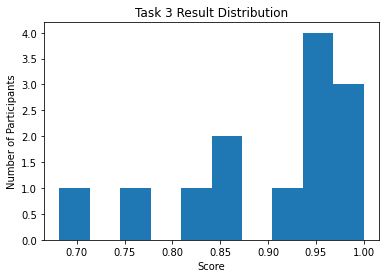

In [23]:
pp.hist(task3_results['accuracy'].head(13))
# pp.xlim([0, 1])
pp.title("Task 3 Result Distribution")
pp.xlabel("Score")
pp.ylabel("Number of Participants")
pp.show()